In [1]:
from analyzer.io.trajectory_parser import parse_trajectory
from analyzer.data.geometry import Geometry

import pygeos
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import numpy as np
import pandas as pd

# Setup geometry & measurement area

In [19]:
geometry = pygeos.polygons([(-10, -2), (-10, 7), (10, 7), (10, -2), (-10, -2)])

geometry_pita = Geometry(geometry)
geometry_pita.add_obstacle(pygeos.polygons([(-9, -2), (-9, 0), (9, 0), (9, -2), (-9, -2)]))
geometry_pita.add_obstacle(pygeos.polygons([(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)]))

ma = pygeos.polygons([(-1.5, 0), (-1.5, 5), (1.5, 5), (1.5, 0), (-1.5, 0)])
ml = pygeos.linestrings([(0, 0), (0, 5)])
ml = pygeos.linestrings([(-2.25, 0), (4, 0)])

direction = np.array([-1, 0])

traj = parse_trajectory("demos/uni-directional/traj_UNI_CORR_500_01.txt")

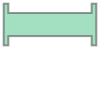

In [21]:
pygeos.to_shapely(geometry_pita.walkable_area)

# Density

## Classic density

In [14]:
from analyzer.methods.density_calculator import compute_classic_density

classic_density = compute_classic_density(traj.data, ma)
classic_density

,classic density
frame,
98,0.0
99,0.0
100,0.0
101,0.0
102,0.0
...,...
1982,0.0
1983,0.0
1984,0.0


In [ ]:
classic_density.reset_index().plot.line(x="frame", y="classic density")

## Voronoi density

In [22]:
from analyzer.methods.density_calculator import compute_voronoi_density

density_voronoi, individual = compute_voronoi_density(traj.data, ma, geometry_pita)

/home/tobias/development/jupedsim/venv-jpsreport-python/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
density_voronoi

In [ ]:
individual

In [ ]:
density_voronoi.reset_index().plot.line(x="frame", y="voronoi density")

In [23]:
density_voronoi_cutoff, individual_cutoff = compute_voronoi_density(
    traj.data, ma, geometry_pita, 1.0, 12
)

/home/tobias/development/jupedsim/venv-jpsreport-python/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
density_voronoi_cutoff.reset_index().plot.line(x="frame", y="voronoi density")

## Comparision

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(
    classic_density.reset_index().frame,
    classic_density["classic density"].values,
    label="classic",
    lw=3,
)
plt.plot(
    density_voronoi.reset_index().frame, density_voronoi["voronoi density"], label="voronoi", lw=3
)
plt.plot(
    density_voronoi_cutoff.reset_index().frame,
    density_voronoi_cutoff["voronoi density"],
    label="voronoi cutoff",
    lw=3,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.legend()
plt.grid()
plt.show()

## Plot voronoi cells

MULTIPOLYGON (((-3.4692337916898475 2.331652566038967, -3.170837329716559 0.0551968315338041, -3.184859609527529 0, -7.877478601278272 0, -3.4692337916898475 2.331652566038967)), ((-9 -0.5937351514757492, -9 -2, -10 -2, -10 -1.1226650695618237, -9 -0.5937351514757492)))


/home/tobias/development/jupedsim/venv-jpsreport-python/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/home/tobias/development/jupedsim/venv-jpsreport-python/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


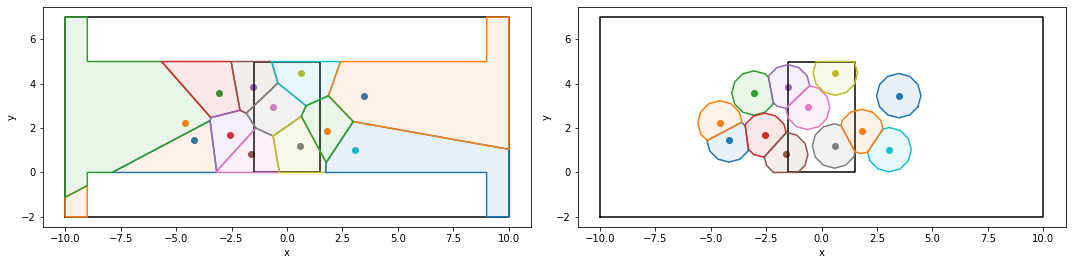

In [31]:
frame_start = 520

for frame in range(frame_start, frame_start + 100, 100):
    fig = plt.figure(figsize=(15, 20))
    ax1 = fig.add_subplot(121, aspect="equal")

    ax1.plot(*pygeos.to_shapely(geometry).exterior.xy, color="k")
    ax1.plot(*pygeos.to_shapely(ma).exterior.xy, color="k")

    df_frame = individual[individual.frame == frame]
    df_frame = pd.merge(traj.data, df_frame, on=["ID", "frame"])
    for _, row in df_frame.iterrows():
        poly = pygeos.to_shapely(row[6])
        if poly.geom_type == 'MultiPolygon':
            print(poly)

            for pp in poly.geoms:
                p = ax1.plot(*pp.exterior.xy)
        elif poly.geom_type == 'Polygon':
            p = ax1.plot(*poly.exterior.xy)

        ax1.scatter(row[2], row[3])
        ax1.add_patch(
            PolygonPatch(
                pygeos.to_shapely(row[6]), alpha=0.1, zorder=2, fc=p[-1].get_color(), ec="none"
            )
        )
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax2 = fig.add_subplot(122, aspect="equal")

    ax2.plot(*pygeos.to_shapely(geometry).exterior.xy, color="k")
    ax2.plot(*pygeos.to_shapely(ma).exterior.xy, color="k")

    df_frame_cutoff = individual_cutoff[individual_cutoff.frame == frame]
    df_frame_cutoff = pd.merge(traj.data, df_frame_cutoff, on=["ID", "frame"])
    for _, row in df_frame_cutoff.iterrows():
        poly = pygeos.to_shapely(row[6])
        if poly.geom_type == 'MultiPolygon':
            for pp in poly.geoms:
                p = ax2.plot(*pp.exterior.xy)
        elif poly.geom_type == 'Polygon':
            p = ax2.plot(*poly.exterior.xy)

        ax2.scatter(row[2], row[3])
        ax2.add_patch(
            PolygonPatch(
                pygeos.to_shapely(row[6]), alpha=0.1, zorder=2, fc=p[-1].get_color(), ec="none"
            )
        )
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    fig.tight_layout()
    plt.show()

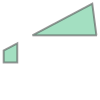

In [33]:
pygeos.to_shapely(pygeos.from_wkt("MULTIPOLYGON (((-3.4692337916898475 2.331652566038967, -3.170837329716559 0.0551968315338041, -3.184859609527529 0, -7.877478601278272 0, -3.4692337916898475 2.331652566038967)), ((-9 -0.5937351514757492, -9 -2, -10 -2, -10 -1.1226650695618237, -9 -0.5937351514757492)))"))

# Velocity

In [ ]:
from analyzer.methods.velocity_calculator import compute_individual_velocity

individual_speed = compute_individual_velocity(traj.data, traj.frame_rate, 5)
individual_speed

In [ ]:
individual_speed.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
individual_speed_direction = compute_individual_velocity(traj.data, traj.frame_rate, 5, direction)
individual_speed_direction

In [ ]:
individual_speed.reset_index().plot.scatter(x="frame", y="speed")

## Mean speed (all)

In [ ]:
from analyzer.methods.velocity_calculator import compute_mean_velocity_per_frame

mean_speed, individual_speed = compute_mean_velocity_per_frame(traj.data, traj.frame_rate, 10)
mean_speed

In [ ]:
mean_speed.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
mean_speed_direction, individual_speed_direction = compute_mean_velocity_per_frame(
    traj.data, traj.frame_rate, 5, direction
)
mean_speed_direction

## Mean speed (in measurement area)

In [ ]:
from analyzer.methods.method_utils import get_peds_in_area
from analyzer.methods.velocity_calculator import compute_mean_velocity_per_frame

peds_in_area = get_peds_in_area(traj.data, ma)
mean_speed_area, individual_speed_area = compute_mean_velocity_per_frame(
    peds_in_area, traj.frame_rate, 5
)

In [ ]:
mean_speed_area.reset_index().plot.scatter(x="frame", y="speed")

In [ ]:
mean_speed_area_direction, individual_speed_area_direction = compute_mean_velocity_per_frame(
    peds_in_area, traj.frame_rate, 5, direction
)

In [ ]:
mean_speed_area_direction.reset_index().plot.scatter(x="frame", y="speed")

## Voronoi speed

In [ ]:
from analyzer.methods.density_calculator import (
    _compute_individual_voronoi_polygons,
    _compute_intersecting_polygons,
)
from analyzer.methods.velocity_calculator import (
    compute_individual_velocity,
    compute_voronoi_velocity,
)

In [ ]:
individual_voronoi = _compute_individual_voronoi_polygons(traj.data, geometry_pita)
intersecting_voronoi = _compute_intersecting_polygons(individual_voronoi, ma)

In [ ]:
voronoi_velocity, individual_velocity = compute_voronoi_velocity(
    traj.data, intersecting_voronoi, traj.frame_rate, 5, ma
)
voronoi_velocity

In [ ]:
voronoi_velocity.reset_index().plot.scatter(x="frame", y="voronoi speed")

In [ ]:
voronoi_velocity_direction = compute_voronoi_velocity(
    traj.data, intersecting_voronoi, traj.frame_rate, 5, ma, direction
)
voronoi_velocity_direction

## Comparison mean velocity vs voronoi velocity

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(voronoi_velocity.reset_index().frame, voronoi_velocity, label="voronoi")
plt.scatter(
    voronoi_velocity_direction.reset_index().frame,
    voronoi_velocity_direction,
    label="voronoi direction",
)
plt.scatter(mean_speed_area.reset_index().frame, mean_speed_area, label="classic")
plt.scatter(
    mean_speed_area_direction.reset_index().frame,
    mean_speed_area_direction,
    label="classic direction",
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.legend()
plt.grid()
plt.show()

# Flow

## N-t diagram

In [ ]:
from analyzer.methods.flow_calculator import compute_n_t

nt, crossing = compute_n_t(traj.data, ml, traj.frame_rate)

In [ ]:
nt.plot(x="Time [s]")

## Flow

In [ ]:
from analyzer.methods.flow_calculator import compute_flow

delta_t = 100
flow = compute_flow(nt, crossing, individual_speed, delta_t, traj.frame_rate)
flow